# Pre Industrial (Try #1)

In [3]:
#load libraries
import xarray as xr
from cftime import DatetimeNoLeap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scipy.stats as stats

In [4]:
#load in data
filepath = '/scratch/rwhite/shared/CESM_PI/dailySSTs/'
temps_filename = 'f.e21.F1850.f09_f09_mg17.DAILYSSTIC_CMIP6-piControl.001.cam.h1.TREFHT.*.nc'
gph_filename = 'f.e21.F1850.f09_f09_mg17.DAILYSSTIC_CMIP6-piControl.001.cam.h1.Z500.*.nc'

#date specifications
year_range = slice('1000', '1070')

# #load data so that it closes and doesn't crash my kernel
with xr.open_mfdataset(filepath+temps_filename) as temp_data:
    date_indices = np.where(temp_data.time.dt.season == 'JJA')[0] #find where dates are in summer
    #allow 5 degrees on top and bottom to account for the boxes centered at either 30 or 60 N
    #select summer days
    temperature_data = temp_data.sel(lat = slice(25,65), time = temp_data.time[date_indices]).TREFHT #select midlatitudes
    temp_data_period = temperature_data.sel(time = year_range)
    
with xr.open_mfdataset(filepath + gph_filename) as geop_data:
    #select midlatitudes + buffer region and select summer days
    gph_data = geop_data.sel(lat = slice(15,75),time = geop_data.time[date_indices]).Z500 #add 15 degrees of buffer
    gph_data_period = gph_data.sel(time = year_range) #select days in 70 year period

#### Steps
    -for each gridpoint calculate TXx and take linear regression

In [5]:
#calculate temperature trends at each gridpoint
latitudes = temp_data_period.lat
longitudes = temp_data_period.lon

#make array that will have the temperature trends
trends = np.zeros((len(longitudes), len(latitudes)))
TXx_NH = temp_data_period.groupby('time.year').max().values
counter = 0
for i,lon in enumerate(longitudes):
    for j,lat in enumerate(latitudes):
        temp_field = TXx_NH[:,j,i] #select temperature field at lon,lat
        TXx = temp_field
        time = temp_data_period.groupby('time.year').mean().year #make time array
        trend = stats.linregress(time, TXx).slope
        trends[i,j] = trend
        
        #check if array is actually working
        if counter % 1000 == 0:
            print(counter)
        counter +=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [6]:
#make Data Array
trends_map = xr.DataArray(trends.T, coords = {"lat": latitudes,"lon":longitudes}, dims = ['lat', 'lon'])
#trends_map.to_netcdf('/scratch/rwhite/jrobs12/analogue_data/cmip6_1000-1070_trends1.nc')

Text(0.5, 1.0, 'Temperature Trends Over Midlatitues for 1000-1070')

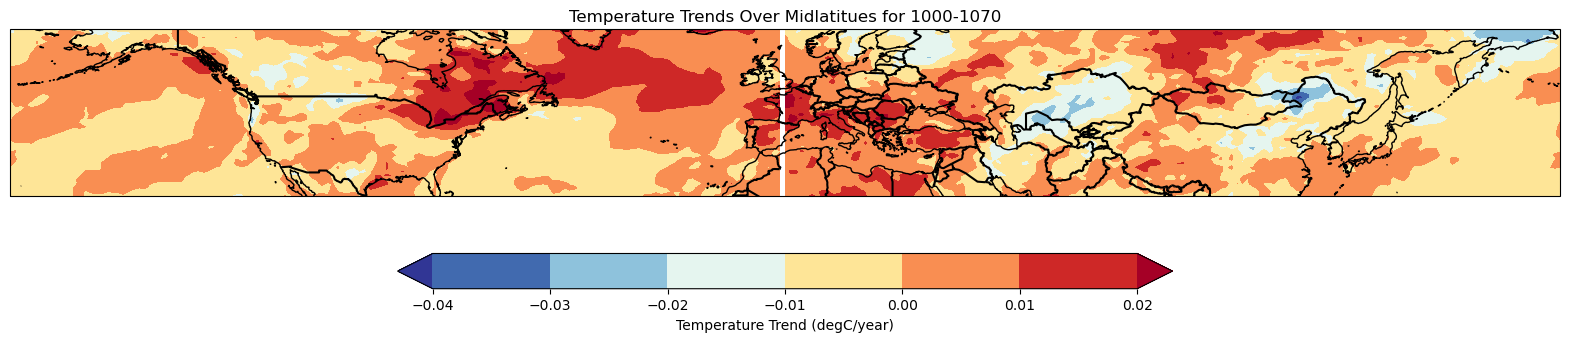

In [7]:
#plot trends
plt.figure(figsize = (20,5))
ax = plt.subplot(projection = ccrs.PlateCarree())
plt.contourf(trends_map.lon, trends_map.lat, trends_map.values, extend = 'both', transform = ccrs.PlateCarree(), cmap = 'RdYlBu_r')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
plt.colorbar(orientation = 'horizontal', shrink = 0.5, label = 'Temperature Trend (degC/year)')
plt.title("Temperature Trends Over Midlatitues for 1000-1070")